# Forward model

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')

In [16]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

### Create volume

Text(0.5, 1.0, 'Volume_comp MIP')

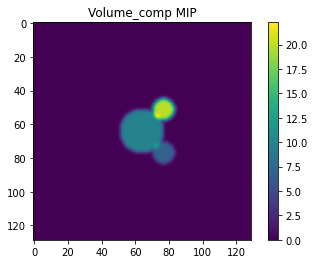

In [6]:
shape = np.array([129,129,129])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

v = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, True))

mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

Text(0.5, 1.0, 'Vol FFT slice')

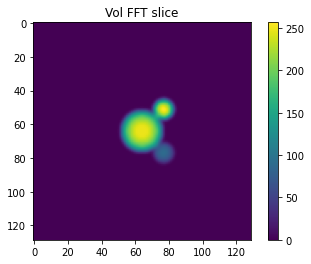

In [9]:
angles = jnp.array([0,0,0])

v_slice = project_spatial(v, angles, dimensions)

plt.imshow(v_slice); plt.colorbar()
plt.title('Vol FFT slice')

In [99]:
@jax.jit
def slice_func(angles):
    return project_spatial(v, angles, dimensions)

@jax.jit
def slice_func_array(angles):
    return jnp.apply_along_axis(slice_func, 1, angles)

In [115]:
angles = jnp.array([np.pi,np.pi/3*2,np.pi/4])

start = time.time()
s1 = slice_func(angles)
print(time.time()-start)

start = time.time()
s2 = slice_func_array(jnp.array([angles]))
print(time.time()-start)

#plt.imshow(slice_tri); plt.colorbar()
#plt.title("Tri")

0.04290294647216797
0.036041259765625


In [224]:
angles_true = jnp.array(np.random.rand(1000,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(angles_true)
print(time.time()-start)

imgs.shape

0.8077371120452881


(1000, 129, 129)

In [235]:
@jax.jit
def loss_func(a):
    return 1/(2* 16641) * jnp.sum((slice_func(a) - img1)**2)

def loss_func_array(a):
    return 1/(2 * 16641000) * jnp.sum((slice_func_array(a) - imgs)**2)

dloss = jax.jit(jax.grad(loss_func_array))

In [238]:
dloss(angles).shape

(1000, 3)

In [245]:
start = time.time()
loss_func_array(angles_true)
print(time.time()-start)

0.764664888381958


In [192]:
start = time.time()
dloss(a_true)
print(time.time()-start)

0.04979109764099121


In [249]:
#a0 = jnp.array(np.random.rand(1000,3))*jnp.pi*2
a0 = jnp.array(angles_true) + 0.1
alpha = 0.01
a = a0
iters = 100
for i in range(iters):
    #if np.mod(i,100) == 0:
        #print(i)
    print(str(i) + ": loss = " + str(loss_func_array(a)))

    a = a - alpha * dloss(a)

0: loss = 23.168457
1: loss = 22.154924
2: loss = 21.175106
3: loss = 20.228867
4: loss = 19.317863
5: loss = 18.442732
6: loss = 17.602806
7: loss = 16.796654
8: loss = 16.024374
9: loss = 15.28665
10: loss = 14.581525
11: loss = 13.909179
12: loss = 13.267787
13: loss = 12.658485
14: loss = 12.080671
15: loss = 11.531331
16: loss = 11.011856
17: loss = 10.520184
18: loss = 10.055932
19: loss = 9.616282
20: loss = 9.201259
21: loss = 8.809671
22: loss = 8.43987
23: loss = 8.0911255
24: loss = 7.761413
25: loss = 7.450158
26: loss = 7.155644
27: loss = 6.8768477
28: loss = 6.612956
29: loss = 6.363284
30: loss = 6.1266713
31: loss = 5.902341
32: loss = 5.689223
33: loss = 5.4871893
34: loss = 5.2950783
35: loss = 5.11203
36: loss = 4.938466
37: loss = 4.773885
38: loss = 4.6174536
39: loss = 4.4684596
40: loss = 4.327147
41: loss = 4.1920877
42: loss = 4.063613
43: loss = 3.9418795
44: loss = 3.8256502
45: loss = 3.7149315
46: loss = 3.6094193
47: loss = 3.5086865
48: loss = 3.4122586


In [216]:
a - jnp.array(a_true)

DeviceArray([ 5.8412552e-05,  9.0599060e-06, -5.9604645e-05], dtype=float32)

## Nearest neighbour interpolation doesn't work yet with JAX

3.1948089599609375e-05


Text(0.5, 1.0, 'NN')

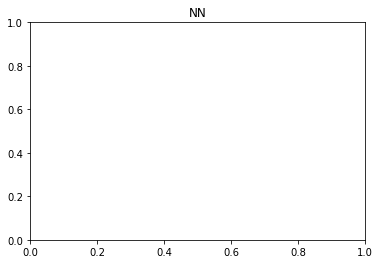

In [121]:
start = time.time()
slice_nn = project_spatial(v, angles, dimensions, "nn")
print(time.time()-start)


plt.imshow(slice_nn); plt.colorbar()
plt.title("NN")